In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import clip as clip
from tqdm import tqdm
from architecture import *
import gc

In [ ]:
D = np.load("data/dict/mscoco_clip_centered.npy")
D = torch.tensor(D).float().T 
device = "cuda" if torch.cuda.is_available() else "cpu"

print(D.shape)
print(D[0].norm())
print(D[:,0].norm())
_, s, _ = np.linalg.svd(torch.matmul(D.T, D).cpu().numpy())
print(s)

D = np.load("data/dict/mscoco_clip.npy")
D = torch.tensor(D).float().T 
device = "cuda" if torch.cuda.is_available() else "cpu"

_, s, _ = np.linalg.svd(torch.matmul(D.T, D).cpu().numpy())
print(s)

In [2]:
D = np.load("data/dict/mscoco_clip_centered.npy")
D = torch.tensor(D).float().T 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(D.shape)
D.to(device)
"""
_, s, _ = np.linalg.svd(torch.matmul(D.T, D).cpu().numpy())
print(s)
"""

model = SparseDeepUnrolling(W = D,
    embedding_dim = 512,
    dict_size = 2000,
    num_layers = 200,
    lam = 1,
    step = .08,
    device = device)

with torch.no_grad():
    t = torch.randn(1, 512, 1).to(device) 
    xhat, zhat = model(t / t.norm())

cuda
torch.Size([512, 10000])


In [4]:
print(xhat, zhat)

print(torch.linalg.norm(xhat), torch.linalg.norm(zhat))

tensor([[[-6.4297e-03],
         [ 1.6508e-02],
         [ 3.8716e-03],
         [ 6.7452e-03],
         [-6.1774e-03],
         [-2.3280e-04],
         [-1.1430e-02],
         [-1.5350e-03],
         [ 5.3836e-03],
         [ 8.4417e-03],
         [ 6.7833e-03],
         [-2.4202e-04],
         [-2.7587e-03],
         [-5.7910e-04],
         [ 1.4430e-02],
         [ 7.0140e-03],
         [ 5.3035e-03],
         [-8.4352e-03],
         [ 3.1374e-03],
         [-1.6702e-03],
         [-8.0523e-03],
         [ 4.2817e-03],
         [ 5.4237e-04],
         [ 6.3820e-03],
         [-4.9109e-03],
         [-4.4572e-03],
         [ 2.0693e-03],
         [-5.0903e-03],
         [-5.8716e-03],
         [-2.5932e-03],
         [ 1.2819e-04],
         [ 1.1006e-03],
         [ 9.1766e-03],
         [-1.7646e-03],
         [-6.1377e-03],
         [ 1.1161e-02],
         [ 3.1320e-03],
         [ 5.7708e-03],
         [ 6.8997e-03],
         [ 1.1224e-02],
         [-4.4581e-03],
         [-1.061

In [6]:
val_images = torch.tensor(np.load("data/embeddings/val_centered.npy")).float()

t1 = val_images[20:60].reshape(-1, 512, 1).float()
with torch.no_grad():
    xs, zs = model(t1)

xs = xs.to("cpu")
zs = zs.to("cpu")




In [24]:
print(xs.shape)
print(zs.shape)
#print(xs.norm(dim=1))

print(xs[0].norm(p=2))
print((t1[0]-xs[0]).norm(p=2))
print(zs[0].norm(p=1))

#zs = zs.to("cpu")
#print(zs[0].flatten().sort())

print(model.W.shape)
print(model.W[:,0].norm())

torch.Size([40, 512, 1])
torch.Size([40, 10000, 1])
tensor(0.1494)
tensor(0.9364)
tensor(0.4996)
torch.Size([512, 10000])
tensor(1.0000, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
print(torch.dot(xs[0, :].flatten() / xs[0].norm(), val_images[20]))

print(model.W.shape)
print(model.W[0].shape)
print(model.W[0].norm())
print(model.W[:, 0].shape)
print(model.W[:, 0].norm())
print(model.W[0])
F.normalize(model.W, dim=0)

In [66]:
## FROM SPLICE
    
class ADMM():
    def __init__(self, rho=1., l1_penalty=0.2, tol=1e-6, max_iter=10000, device="cuda", verbose=False):
        self.rho = rho
        self.l1_penalty = l1_penalty
        self.tol = tol
        self.max_iter = max_iter
        self.device = device
        self.verbose = verbose

    def step(self, Cb, Q_cho, z, u):
        xn = torch.cholesky_solve(2*Cb + self.rho*(z - u), Q_cho)
        zn = torch.where((xn + u - self.l1_penalty/self.rho) > 0, xn + u - self.l1_penalty/self.rho, 0)
        un = u + xn - zn
        return xn, zn, un
    
    def fit(self, C, v):
        ## iterates are in c, the number of concepts
        c = C.shape[0]

        ## size: c x c
        Q = 2*C @ C.T + (torch.eye(c)*self.rho).to(self.device)

        # factor Q for quicker solve -- this is critical.
        Q_cho = torch.linalg.cholesky(Q)

        # iterates, size: c x batch
        x = torch.randn((c, v.shape[0])).to(self.device)
        z = torch.randn((c, v.shape[0])).to(self.device)
        u = torch.randn((c, v.shape[0])).to(self.device)

        for ix in range(self.max_iter):
            z_old = z
            x, z, u = self.step(C@v.T, Q_cho, z, u)

            res_prim = torch.linalg.norm(x-z, dim=0)
            res_dual = torch.linalg.norm(self.rho*(z-z_old), dim=0)

            if (res_prim.max() < self.tol) and (res_dual.max() < self.tol):
                break
        if self.verbose:
            print("Stopping at iteration {}".format(ix))
            print("Prime Residual, r_k: {}".format(res_prim.mean()))
            print("Dual Residual, s_k: {}".format(res_dual.mean()))
        return z.T

class SparseDeepUnrolling(nn.Module):
    ## This section is largely inspired by the code from the paper: "Stable and Interpretable Unrolled Dictionary Learning Deep Networks"
    ## https://github.com/btolooshams/stable-interpretable-unrolled-dl/blob/master/src/model.py
    def __init__(self, W = None, **kwargs):
        super().__init__()
        self.device = kwargs.get('device', 'cpu')
        
        self.D = kwargs.get('embedding_dim', 512)
        self.P = kwargs.get('dict_size', 1000)
        self.T = kwargs.get('num_layers', 10)

        
        self.lam = kwargs.get('lam', 0.12)

        if W is None:
            W = F.normalize(torch.randn((self.D, self.P), device=self.device), p=2, dim=0)
        else:
            W = F.normalize(W.to(self.device), p=2, dim=0)

        self.register_parameter('W', nn.Parameter(W))
        self.register_buffer("step", torch.tensor(kwargs.get('step', .1)))
        self.relu = nn.ReLU()

    def normalize(self):
        self.W.data = F.normalize(self.W.data, p=2, dim=0)

    def get_params(self):
        return self.state_dict(keep_vars=True)

    def forward(self, x):
        x = x.to(self.device)
        batch_size = x.shape[0]
        zhat = torch.zeros((batch_size, self.P, 1), device=self.device)
        IplusWTW = torch.eye(self.P, device=self.device) - self.step * torch.matmul(self.W.T, self.W)
        WTx = self.step * torch.matmul(self.W.T, x)
        #print(IplusWTW.shape, zhat.shape, WTx.shape)
        for _ in range(self.T):
            zhat = self.relu(torch.matmul(IplusWTW, zhat) + WTx - self.lam * self.step)

        xhat = torch.matmul(self.W, zhat)

        return xhat, zhat


admm_solver = ADMM(rho=5, l1_penalty=.1, tol=1e-6, max_iter=2000, device="cuda", verbose=False)
r = admm_solver.fit(D.to(device).T, t1.reshape(-1, 512).to(device)).to(device)


In [85]:

sdu_model = SparseDeepUnrolling(W = D,
    embedding_dim = 512,
    dict_size = 10000,
    num_layers = 100,
    lam = .00,
    step = .002,
    device = device)

t1 = val_images[20:40].reshape(-1, 512, 1).float()

#sdu_model.forward(t1)


In [95]:
vals = list(range(1, 10)) + list(range(10, 100, 10)) + list(range(100, 1000, 100))
step_sizes = [.003, .002, .001]

all_norms = []
all_euc_dist = []
for step in step_sizes:
    norms = []
    euc_dist = []
    for T in vals:
        sdu_model = SparseDeepUnrolling(W = D,
            embedding_dim = 512,
            dict_size = 10000,
            num_layers = T,
            lam = .00,
            step = step,
            device = device)
        t1 = val_images[20:40].reshape(-1, 512, 1).float()
        with torch.no_grad():
            xhat, zhat = sdu_model.forward(t1)
        norms.append(torch.linalg.norm(xhat, dim=0).mean().item())
        euc_dist.append(torch.linalg.norm(xhat.cpu()     - t1, dim=0).mean().item())
    all_norms.append(norms)
    all_euc_dist.append(euc_dist)

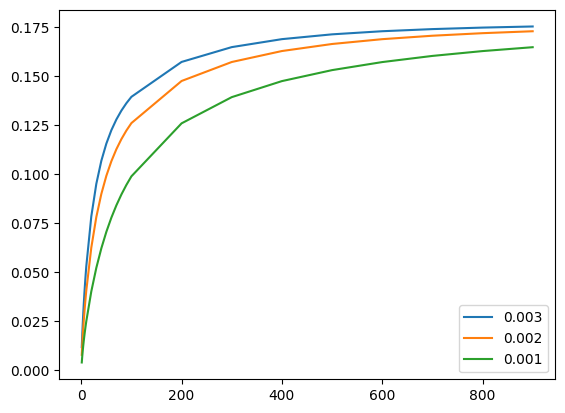

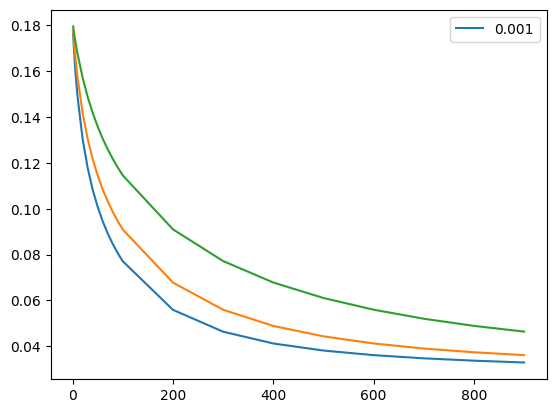

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900]
[0.003908532205969095, 0.007189538329839706, 0.010052565485239029, 0.012623542919754982, 0.014981696382164955, 0.017178582027554512, 0.01924780383706093, 0.02121240831911564, 0.023089438676834106, 0.02489064261317253, 0.04012478142976761, 0.052154622972011566, 0.06210003048181534, 0.07051495462656021, 0.07774747908115387, 0.08403964340686798, 0.0895674079656601, 0.09446525573730469, 0.09883581846952438, 0.12584620714187622, 0.13920316100120544, 0.14738264679908752, 0.15298406779766083, 0.1570870280265808, 0.16022509336471558, 0.16269171237945557, 0.16467201709747314]


In [98]:
for l in all_norms:
    plt.plot(vals, l)
plt.legend(step_sizes)
plt.show()

for l in all_euc_dist:
    plt.plot(vals, l)
plt.legend(step_sizes[2:])
plt.show()

print(vals)
print(norms)